<a href="https://colab.research.google.com/github/Mark-Barbaric/Kaggle/blob/AP-36-Fine-tune-BERT-Pretrained-Model-for-Disaster-Tweets/disaster_tweets/NLP_With_Disaster_Tweets_Pretrained_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F17777%2F869809%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240724%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240724T071108Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D20d6ecea972c4dc584acdf62d0e2e81c3e8fff0e379f16deacef5ca2594a0d7910f1eac7339d38c8bda1f99910cab2fb6a7e21948f183ae1b372f5feeabcd4c276fcb537fd4842547248104f1dec0c3b4c73580c374e73e635d2cb0f725ce1279a68d817fcaf6394ecda5d40fdf029ad537a88665ac7af93925f67ed34b5f4e4ba002dd6cc7318e4595ffa6dda69f0cedc7f2754723b5fbf4a353fc52b1986b45ffafdbcc3c692ae53e4e710dcb5014f8cc768a28dc3db05796907940507b41e95ac384039d1b7872b0cf0a9ab9051c5f89d25f2327e71dfe60f75559864e5c9238a9454c23fc58b1f1f5a93e6652154f5f1918de20b77ef2b380f520a15229c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: nlp-getting-started
Data source import complete.


# Disaster Tweets Using KerasNLP and Pretrained BERT

![image.png](attachment:image.png)

In [2]:
import os

In [3]:
IS_KAGGLE = os.path.exists('/kaggle/input')
print(IS_KAGGLE)

True


If this is being run in Kaggle then the dependencies will need to be installed directly into the image.

In [4]:
if IS_KAGGLE:
    print("Installing additional libs")
    !pip install keras-core --upgrade
    !pip install -q keras-nlp --upgrade
    !pip install nltk tweet-preprocessor

Installing additional libs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 41.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow

In [5]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

## Lib Imports

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend


In [7]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

ENGLISH_STOPWORDS = set(stopwords.words('english'))

# Local Helper Method Imports

Adding local path to sys path to add lib

In [9]:
import sys
from pathlib import Path

current_path = Path.cwd()
print(f"current_path: {current_path}")
sys.path.append(current_path)

current_path: /content


In [10]:
#from disaster_tweet_helpers import preprocess_text

In [11]:
import preprocessor as tweet_preprocessor
import string


def preprocess_text(text, stopwords):
    """_summary_

    Args:
        df (_type_): _description_
        column_name (_type_): _description_
        stopwords (_type_): _description_
    """
    def remove_punctuations(text: str):
        for punctuation in string.punctuation:
            text = text.replace(punctuation, '')
        return text

    text = text.lower()
    text = remove_punctuations(text)
    text = text.replace('\s\s+', ' ')
    text = tweet_preprocessor.clean(text)
    text = ' '.join([w for w in text.split(' ') if w not in stopwords])
    return text

# Constants

In [12]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
BATCH_SIZE = 32
Y_COLUMN = 'target'
MODEL_VERSION = 1

In [28]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Not running in Colab")

Mounted at /content/drive


## 1. Dataset Loading and Analysis

### 1.1 Train and Test Dataset Loading

In [14]:
TRAIN_DF_DIR = '/kaggle/input/nlp-getting-started/train.csv' if IS_KAGGLE else 'train.csv'
TEST_DF_DIR = '/kaggle/input/nlp-getting-started/test.csv' if IS_KAGGLE else 'test.csv'

In [15]:
train_df = pd.read_csv(TRAIN_DF_DIR)
test_df = pd.read_csv(TEST_DF_DIR)

In [16]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### 1.2 EDA

In [18]:
train_df['preprocessed_text'] = train_df['text'].apply(lambda x: preprocess_text(x, ENGLISH_STOPWORDS))
train_df.head()

,id,keyword,location,text,target,preprocessed_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


In [19]:
train_df['length'] = train_df['preprocessed_text'].apply(lambda x: len(x.split(' ')))
train_df.head()

,id,keyword,location,text,target,preprocessed_text,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,7
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,11
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,6
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,9


<Axes: >

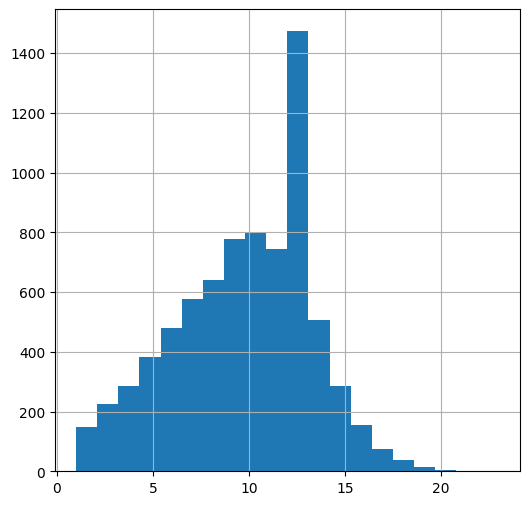

In [20]:
train_df['length'].hist(bins=20, figsize=(6, 6))

In [21]:
train_df['length'].describe()

count    7613.000000
mean        9.691712
std         3.526706
min         1.000000
25%         7.000000
50%        10.000000
75%        12.000000
max        23.000000
Name: length, dtype: float64

In [22]:
X = train_df['text']
y = train_df[Y_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6090,)
X_test shape: (1523,)
y_train shape: (6090,)
y_test shape: (1523,)


In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## 2. Model Loading and Fine Tuning

In [24]:
preset = 'distil_bert_base_en_uncased'
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name='preprocessor_4_tweets')
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, num_classes=2)
classifier.summary()

100%|██████████| 140/140 [00:00<00:00, 204kB/s]


100%|██████████| 580/580 [00:00<00:00, 581kB/s]


100%|██████████| 226k/226k [00:00<00:00, 1.19MB/s]


100%|██████████| 515/515 [00:00<00:00, 722kB/s]


100%|██████████| 253M/253M [00:04<00:00, 54.9MB/s]


Preprocessor: "distil_bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Model Fine Tuning

In [25]:
N_EPOCHS = 15

In [26]:
def train_model(train_model, train_dataset, validation_dataset):
    train_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-5),
        metrics=['accuracy']
    )
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = train_model.fit(train_dataset.batch(BATCH_SIZE),
                              epochs=N_EPOCHS,
                              validation_data=validation_dataset.batch(BATCH_SIZE),
                              callbacks=[early_stopping_callback],
                              shuffle=True,
                              verbose=True)
    return history

def save_model_to_google_drive(classifier, model_name, model_version):
    DRIVE_DIR = f"drive/MyDrive/AI/models/kaggle/nlp_with_disaster_tweets/bert/{model_name}_v{model_version}.keras"
    classifier.save(DRIVE_DIR)

In [27]:
history = train_model(classifier, train_dataset, validation_dataset)

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 176s 704ms/step - accuracy: 0.7262 - loss: 0.5669 - val_accuracy: 0.8437 - val_loss: 0.3918
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 95s 495ms/step - accuracy: 0.8490 - loss: 0.3751 - val_accuracy: 0.8464 - val_loss: 0.3829
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 95s 496ms/step - accuracy: 0.8746 - loss: 0.3217 - val_accuracy: 0.8418 - val_loss: 0.3941
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 95s 495ms/step - accuracy: 0.8980 - loss: 0.2781 - val_accuracy: 0.8326 - val_loss: 0.4180
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 95s 494ms/step - accuracy: 0.9159 - loss: 0.2380 - val_accuracy: 0.8332 - val_loss: 0.4603


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/AI/models/kaggle/nlp_with_disaster_tweets/bert/pretrained_bert_v1.keras'

In [29]:
save_model_to_google_drive(classifier, 'pretrained_bert', MODEL_VERSION)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*n_batches)

In [ ]:
#classifier = tf.keras.models.load_model('drive/MyDrive/AI/models/kaggle/nlp_with_disaster_tweets/bert/pretrained_bert_v1.keras')

## 3. Model Evaluation

In [30]:
y_pred_raw = classifier.predict(X_test)
y_pred = np.argmax(y_pred_raw, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step


In [31]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       908
           1       0.78      0.82      0.80       615

    accuracy                           0.83      1523
   macro avg       0.83      0.83      0.83      1523
weighted avg       0.84      0.83      0.83      1523



## 4. Kaggle Submission

In [40]:
y_test_pred_raw = classifier.predict(test_df['text'])
y_test_pred = np.argmax(y_test_pred_raw, axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step


In [41]:
y_test_pred

array([1, 1, 1, ..., 1, 1, 1])

In [42]:
submission_df = pd.DataFrame({'id': test_df['id'].values, 'target': y_test_pred})
submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [45]:
submission_df.to_csv(f"submission_{MODEL_VERSION}.csv", index=False)